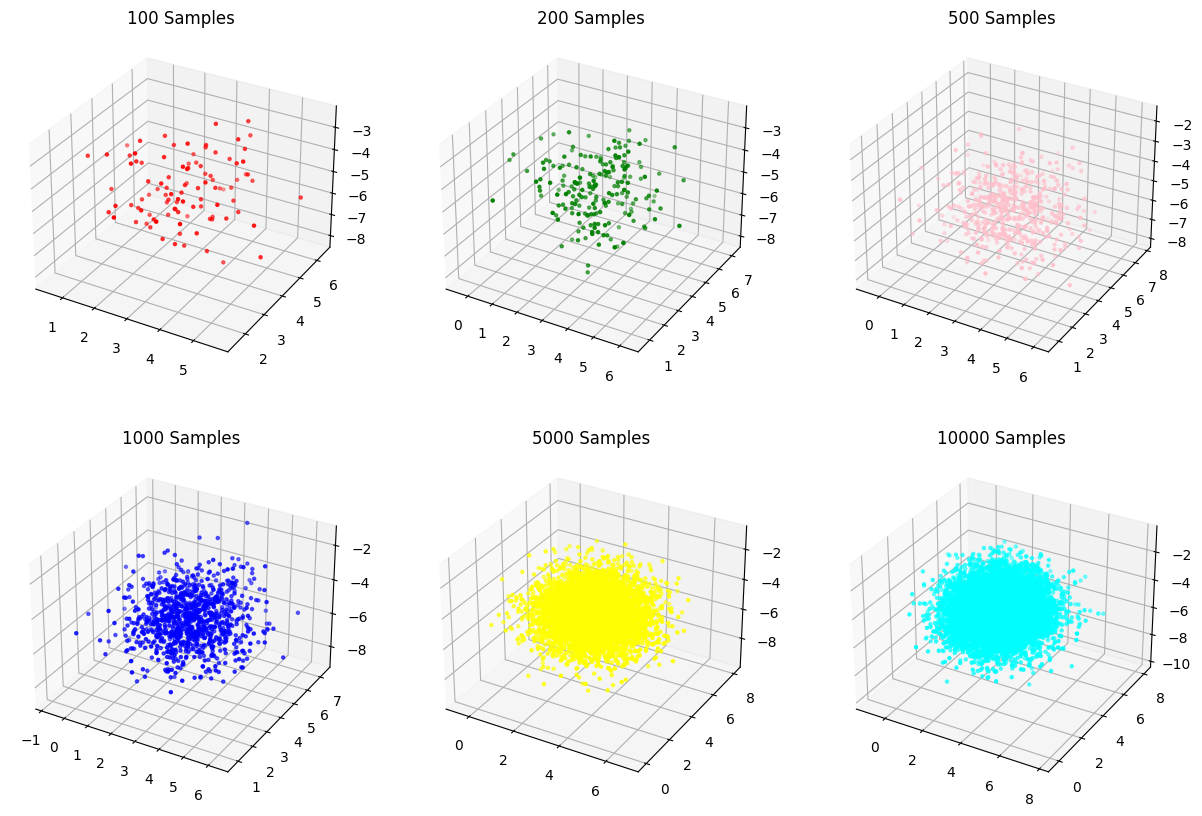

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mean_vec = np.array([3,4,-5])
cov_mat = 1.2 * np.identity(3)
num_samples = [100, 200, 500, 1000,5000,10000]
colors=['red','green','pink','blue','yellow','cyan']
estimated_ml_means={}
estimated_mmse_means={}
ml_errors={}
mmse_errors={}
fig = plt.figure(figsize=(15,10))
for idx,i in enumerate(num_samples):
    x = np.random.multivariate_normal(mean_vec, cov_mat,i)
    est_mean1 = np.mean(x,axis=0)
    est_mean2 = np.mean(x, axis=0) + np.dot(np.linalg.inv(cov_mat), np.sum(x - np.mean(x, axis=0), axis=0))
    estimated_ml_means[i] = est_mean1
    estimated_mmse_means[i] = est_mean2
    ml_errors[i] = np.mean((mean_vec - est_mean1)**2)
    mmse_errors[i] = np.mean((mean_vec - est_mean2)**2)
    ax = fig.add_subplot(2,3,idx+1,projection='3d')
    ax.scatter(x.T[0][:], x.T[1][:], x.T[2][:], marker='.',color=colors[idx])
    ax.set_title(str(len(x)) + ' Samples')
plt.show()

100-Samples : ML-Error=0.00114307611416724 and MMSE-Error=0.0011430761141645361
200-Samples : ML-Error=0.003999233923786053 and MMSE-Error=0.003999233923811505
500-Samples : ML-Error=0.012285528488456548 and MMSE-Error=0.012285528488516032
1000-Samples : ML-Error=0.0005223117011049875 and MMSE-Error=0.0005223117012026956
5000-Samples : ML-Error=0.0003348149349077524 and MMSE-Error=0.0003348149349156437
10000-Samples : ML-Error=0.0001809178655623546 and MMSE-Error=0.00018091786450049328


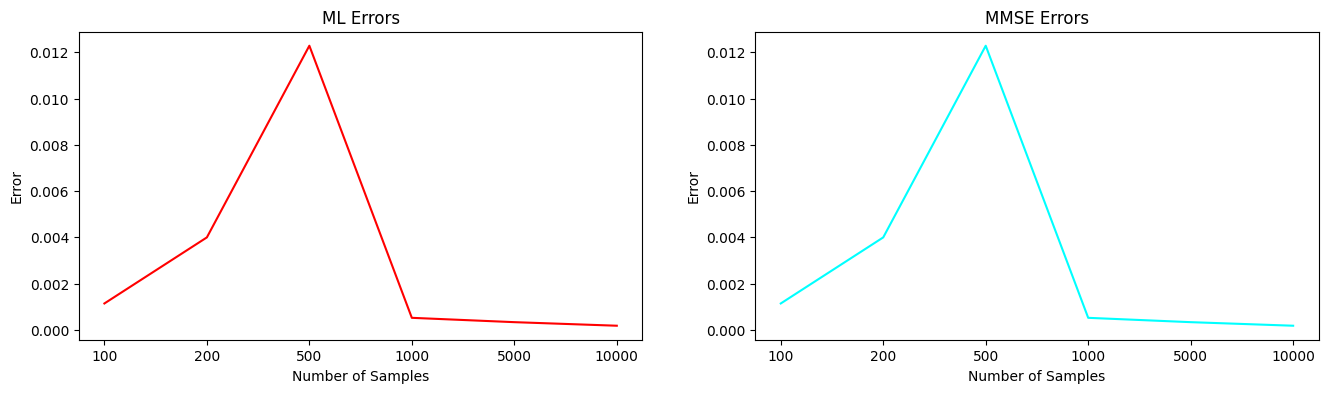

In [2]:
for sam,ml,mmse in zip(ml_errors.keys(),ml_errors.values(),mmse_errors.values()):
    print("{}-Samples : ML-Error={} and MMSE-Error={}".format(sam,ml,mmse))

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
ax.plot(ml_errors.values(),color='red')
ax.set_xticks(range(6),ml_errors.keys())
ax.set_title('ML Errors')
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Error')

ax = fig.add_subplot(1,2,2)
ax.plot(mmse_errors.values(),color='cyan')
ax.set_xticks(range(6),mmse_errors.keys())
ax.set_title('MMSE Errors')
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Error')
plt.show()

# EM Algorithm

#### **Step-1: Initialization**

In [3]:
def initialization(data,K):
    
  d=data.shape[1] # dimension of data

  # mean initialization  
  pick_means=np.random.randint(0,data.shape[0],K)
  means=data[pick_means,:]
  means=np.transpose(means)
    
  # covariance matrix initialization  
  Covariance=np.zeros((d,d,K))
  for i in range(K):
    Covariance[:,:,i]=np.eye(d)*np.max(data,axis=None)    

  #mixing coefficients  
  proportions=np.ones((K,1))/K
  theta=[means,Covariance,proportions]

  return theta

#### **Step 2: Expectation stage**

$$\gamma_{ik}=\frac{w_{k}P(x_{i}|\Phi_{k})}{\sum_{k=1}^{K}w_{k}P(x_{i}|\Phi_{k})}$$
where,
$$\Phi_{k}=\{\mu_{k},\Sigma_{k}\}$$
$$\theta_{k}=\{\Phi_{k},w_{k}\}$$
$$w_{k}=\frac{N_{k}}{N}$$
$$N_{k}=\sum_{i=1}^{N}\gamma_{ik}$$
$$P(x_{i}|\Phi_{k})=\frac{1}{(2 \pi)^{d/2}|\Sigma_{k}|^{1/2}}e^{-(x_{i}-\mu_{k})^{T}\Sigma_{k}^{-1}(x_{i}-\mu_{k})}$$

In [4]:
from scipy.stats import multivariate_normal
def E_Step_GMM(data,K,theta):
    
    means=theta[0]
    Covariance=theta[1]
    proportions=theta[2]
    
    responsibility=np.zeros((len(data),K))#Computing responsibility coefficients of each point for each cluster.
    
    for i in range(K): #Running for K number of time i.e., Number of clusters
        itr=0   # increase w.r.t datapoint 
        
        for x in data:
            
            normalising=0 ## Denomintor

            # Compute probability of xj for cluster i 
            N_xn=multivariate_normal.pdf(x,mean=means[:,i], cov=Covariance[:,:,i])
            # # only to avoid 
            # if N_xn<10**(-20):
            #   N_xn=10**(-20)
            responsibility[itr][i]=proportions[i]*N_xn
            
            for j in range(K):
                normalising+=proportions[j]*(multivariate_normal.pdf(x,mean=means[:,j], cov=Covariance[:,:,j])+10**(-20))
                
            responsibility[itr][i]=responsibility[itr][i]/normalising
            
            itr+=1

    
    return responsibility

#### **Step-3: Maximization Stage**

a) $w_{k}=\frac{N_{k}}{N}$, where  $N_{k}=\sum_{i=1}^{N}\gamma_{ik}$

b) $\mu_{k}=\frac{\sum_{i=1}^{N}\gamma_{ik}x_{i}}{N_{k}}$

c) $\Sigma_{k}=\frac{\sum_{i=1}^{N}\gamma_{ik}(x_{i}-\mu_{k})(x_{i}-\mu_{k})^{T}}{N_{k}}$

Objective function(maximized through iteration):
$$L(\theta)=\sum_{i=1}^{N}log\sum_{k=1}^{K}w_{k}P(x_{i}|\Phi_{k})$$ 

In [5]:
def M_Step_GMM(data,responsibility):
    
    [N,K]=np.shape(responsibility) #N is number of data points
    d=data.shape[1]
    Nk=np.sum(responsibility,axis=0)
    proportions=Nk/N
    means=np.zeros((K,d))  
    
    for k in range(K):
        temp1=data
        temp2=responsibility[:,k]
        temp=temp1*temp2[:,None] #multiplying a vector with multiple columns
        means[k]=(1/Nk[k])*np.sum(temp,axis=0)  
    means=np.transpose(means)
    
    Covariance=np.zeros((d,d,K))        
    for k in range(K):
        for n in range(N):
            temp1=data[n,:]-means[:,k]
            temp2=np.outer(temp1,np.transpose(temp1)) # vector outer product
            temp=responsibility[n,k]*temp2
            Covariance[:,:,k]+=temp
        Covariance[:,:,k]=(1/Nk[k])*Covariance[:,:,k]

    
    theta=[means,Covariance,proportions]
    
    Likelihood=0
    log_likelihood=0
    
    for n in range(N):
        for k in range(K):
            Likelihood+=proportions[k]*(multivariate_normal.pdf(data[n,:],mean=means[:,k], cov=Covariance[:,:,k]))
        log_likelihood+=np.log(Likelihood)  
        
    return theta, log_likelihood

# GMM

### Dataset Generation

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

iris_data_file = open('iris/iris.data','r')
lines = iris_data_file.readlines()[:-1]
iris_data = []
for i in lines:
    try:
        point = i[:-2].split(',')
        if point[-1] == 'Iris-setos':
            label = 0
        elif point[-1] == 'Iris-versicolo':
            label = 1
        else:
            label = 2
        a=float(point[0])
        b=float(point[1])
        c=float(point[2])
        d=float(point[3])
        one_point = [a,b,c,d,label]
        iris_data.append(one_point)
    except:
        continue
        
iris_data = np.array(iris_data)
X = iris_data[:,:-1]
y = iris_data[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=42)
print('Training Data  : ',X_train.shape,y_train.shape)
print('Testing Data   : ',X_test.shape,y_test.shape)

Training Data  :  (120, 4) (120,)
Testing Data   :  (30, 4) (30,)


### Without Inbuilt Function

In [7]:
log_l=[]
Itr=250
eps=10**(-14)  # for threshold
K = 3   # no. of clusters
# data=(X_train-(np.mean(X_train,axis=0)))/(np.std(X_train,axis=0)) # data normalization
data = X_train
theta=initialization(data,K)
iter=0
for n in range(Itr):
  responsibility=E_Step_GMM(data,K,theta)
  cluster_label=np.argmax(responsibility,axis=1) #Label Points
  theta,log_likhd=M_Step_GMM(data,responsibility)
  log_l.append(log_likhd)
  Cents=theta[0].T
  if n>2:
    if abs(log_l[n]-log_l[n-1])<eps:
      iter=n
      break

from sklearn import metrics
pred_lab=cluster_label
print(pred_lab)
print(y_train)
print('Accuracy = ',metrics.homogeneity_score(pred_lab,y_train))

print(f"Number of iterations needed for convergence: {iter}")
print(f"Converged log-likelihood value: {log_l[-1]}")

[0 0 1 0 0 2 1 0 0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1
 2 0 1 2 0 2 2 1 1 2 1 0 1 2 0 0 1 1 0 2 0 0 2 1 2 2 2 2 1 0 0 2 2 0 0 0 2
 2 0 2 2 0 1 1 2 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2 2 1 2 1
 1 2 2 0 1 2 0 1 2]
[0. 0. 1. 0. 0. 2. 1. 0. 0. 0. 2. 1. 1. 0. 0. 1. 2. 2. 1. 2. 1. 2. 1. 0.
 2. 1. 0. 0. 0. 1. 2. 0. 0. 0. 1. 0. 1. 2. 0. 1. 2. 0. 2. 2. 1. 1. 2. 1.
 0. 1. 2. 0. 0. 1. 1. 0. 2. 0. 0. 1. 1. 2. 1. 2. 2. 1. 0. 0. 2. 2. 0. 0.
 0. 1. 2. 0. 2. 2. 0. 1. 1. 2. 1. 2. 0. 2. 1. 2. 1. 1. 1. 0. 1. 1. 0. 1.
 2. 2. 0. 1. 2. 2. 0. 2. 0. 1. 2. 2. 1. 2. 1. 1. 2. 2. 0. 1. 2. 0. 1. 2.]
Accuracy =  0.9185298404481175
Number of iterations needed for convergence: 82
Converged log-likelihood value: 438.328693811361


In [8]:
print("Means with Manual Calculation :")
theta[0].T

Means with Manual Calculation :


array([[4.99      , 3.44      , 1.4525    , 0.2425    ],
       [5.90755446, 2.7688834 , 4.18873027, 1.29857729],
       [6.49946976, 2.95408136, 5.47504177, 1.97176261]])

### With Using Inbuilt Function

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import preprocessing


gmm = GaussianMixture(n_components=3)
gmm.fit(X_train)


labelss = gmm.predict(X_train)
accc = adjusted_rand_score(labelss,y_train)
print("Training Accuracy : ",accc)


labels = gmm.predict(X_test)
acc = adjusted_rand_score(labels,y_test)


num_iterations = gmm.n_iter_
centers = gmm.means_
print("Testing Accuracy : ",acc)
print(centers)

Training Accuracy :  0.9266186789173232
Testing Accuracy :  0.8989818741826271
[[6.50442412 2.95387167 5.48252847 1.97542369]
 [4.99       3.44       1.4525     0.2425    ]
 [5.90948294 2.77139193 4.19647176 1.30290704]]
